# 2024 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

## imports

In [90]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Dataset Path




In [91]:
db_path = "dataset"

train_file = f"{db_path}/train.json"
test_file = f"{db_path}/test.json"
val_file = f"{db_path}/validation.json"

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [92]:
import json
with open(train_file, "r") as fp:
    train = json.load(fp)
with open(val_file, "r") as fp:
    val = json.load(fp)
with open(test_file, "r") as fp:
    test = json.load(fp)

train['premise']['0'], train['hypothesis']['0'], train['label']['0'], len(train['premise'])



('Pluto rotates once on its axis every 6.39 Earth days;',
 'Earth rotates on its axis once times in one day.',
 'neutral',
 23088)

In [93]:
train['premise']['146']

'*'

In [94]:
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk import pos_tag
import numpy as np


class Config:
    stem = False
    stemmer = PorterStemmer()
    lemmatize = False
    lemmatizer = WordNetLemmatizer()
    tokenize = True

    clean_text = True
    regex = r"[^a-z0-9\-\s]"

    pos = False
    pos_tagger = pos_tag

    lower = True

    stopwords = set(stopwords.words('english'))


class textProcesser():
    def __init__(self, cfg: Config) -> None:
        self.cfg = cfg

        self.lemmatizer = cfg.lemmatizer
        self.stemmer = cfg.stemmer
        self.stop_words = cfg.stopwords


    def clean(self, sentence: str) -> list[str]:
        tokens = [sentence]
        if self.cfg.tokenize:
            tokens = nltk.word_tokenize(sentence)

        if self.cfg.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        if self.cfg.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]

        if self.cfg.clean_text:
                
            tokens = [re.sub(self.cfg.regex, '', token.lower() if self.cfg.lower else token) for token in tokens]
            tokens = [token for token in tokens if token and token not in self.stop_words]

        if self.cfg.pos:
            tokens = self.cfg.pos_tagger(tokens)
        
        return tokens
    
    def clean_text(self, json):
        clean = {'premise': {}, 'hypothesis': {}, 'label': {}}
        for idx, key in enumerate(json['label'].keys()):

            p_clean = self.clean(json['premise'][key])
            h_clean = self.clean(json['hypothesis'][key])

            if len(p_clean) == 0 or len(h_clean) == 0:
                print(f" Warning: Empty premise or hypothesis at index {idx} (key: {key}).")

            if 'neutral' in json['label'][key]:
                clean['label'][idx] = 0
            else:
                clean['label'][idx] = 1

            clean['premise'][idx] = p_clean
            clean['hypothesis'][idx] = h_clean
            
        return clean

In [95]:
clean_train = textProcesser(Config()).clean_text(train)
clean_val = textProcesser(Config()).clean_text(val)
clean_test = textProcesser(Config()).clean_text(test)
clean_train['premise'][146], clean_train['hypothesis'][146], clean_train['label'][146]

([], ['takes', 'earth', 'one', 'week', 'rotate', 'axis', 'seven', 'times'], 0)

In [96]:
import pandas as pd
train_df = pd.DataFrame({
    "label": clean_train["label"],
    "premise": clean_train["premise"],
    "hypothesis": clean_train["hypothesis"]
})

val_df = pd.DataFrame({
    "label": clean_val["label"],
    "premise": clean_val["premise"],
    "hypothesis": clean_val["hypothesis"]
})

test_df = pd.DataFrame({
    "label": clean_test["label"],
    "premise": clean_test["premise"],
    "hypothesis": clean_test["hypothesis"]
})

train_df = train_df.reset_index(drop=True)
train_df.head()

,label,premise,hypothesis
0,0,"[pluto, rotates, axis, every, 639, earth, days]","[earth, rotates, axis, times, one, day]"
1,1,"[--, -glenn, per, day, earth, rotates, axis]","[earth, rotates, axis, times, one, day]"
2,0,"[geysers, -, periodic, gush, hot, water, surfa...","[surface, sun, much, hotter, almost, anything,..."
3,1,"[facts, liquid, water, droplets, changed, invi...","[evaporation, responsible, changing, liquid, w..."
4,1,"[comparison, earth, rotates, axis, per, day, r...","[earth, rotates, axis, times, one, day]"


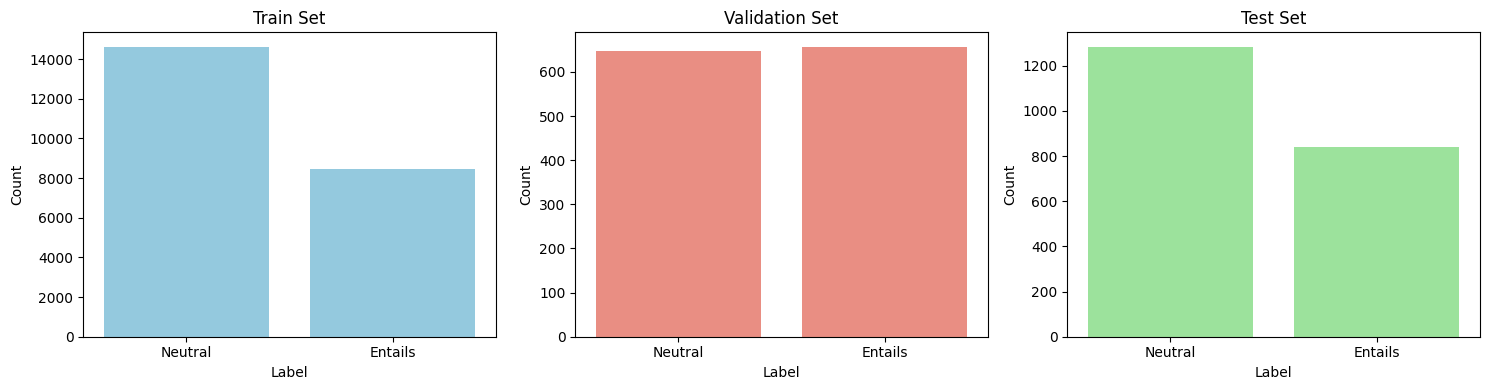

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

splits = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]
colors = ['skyblue', 'salmon', 'lightgreen']  # one color per split

plt.figure(figsize=(15,4))

for i, ((name, df), color) in enumerate(zip(splits, colors), 1):
    plt.subplot(1, 3, i)
    counts = df['label'].value_counts().sort_index()
    sns.barplot(x=['Neutral', 'Entails'], y=counts.values, color=color)
    plt.title(f"{name} Set")
    plt.xlabel("Label")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [98]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

class nliDataset(Dataset):
  def __init__(self, df, embed_model):
    self.df = df
    self.embed_model = embed_model

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    premise = self.df["premise"].iloc[index]
    hypothesis = self.df["hypothesis"].iloc[index]
    p_embed = np.array([self.embed_model.wv[word] for word in premise if word in self.embed_model.wv])
    h_embed = np.array([self.embed_model.wv[word] for word in hypothesis if word in self.embed_model.wv])

    if len(p_embed) == 0:
        p_embed = np.zeros((1, self.embed_model.vector_size))
    if len(h_embed) == 0:
        h_embed = np.zeros((1, self.embed_model.vector_size))
    label = int(self.df["label"].iloc[index])

    p_embed = torch.tensor(p_embed, dtype=torch.float32)
    h_embed = torch.tensor(h_embed, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

    return p_embed, h_embed, label


In [99]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    p_embeds, h_embeds, labels = zip(*batch)

    p_lengths = torch.tensor([x.shape[0] for x in p_embeds], dtype=torch.long)
    h_lengths = torch.tensor([x.shape[0] for x in h_embeds], dtype=torch.long)

    p_padded = pad_sequence(p_embeds, batch_first=True)  # (batch, max_p_len, embed_dim)
    h_padded = pad_sequence(h_embeds, batch_first=True)  # (batch, max_h_len, embed_dim)

    labels = torch.stack(labels)

    return p_padded, h_padded, labels, p_lengths, h_lengths


In [100]:
from gensim.models import Word2Vec
sentences = list(clean_train['premise'].values()) + list(clean_train['hypothesis'].values())
embed_model = Word2Vec(sentences=sentences, vector_size=300, window=10, min_count=3, workers=2, sg=1)


In [101]:
train_db = nliDataset(train_df, embed_model=embed_model)
trainloader = DataLoader(train_db, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_db = nliDataset(val_df, embed_model=embed_model)
valloader = DataLoader(val_db, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_db = nliDataset(test_df, embed_model=embed_model)
testloader = DataLoader(test_db, batch_size=8, shuffle=True, collate_fn=collate_fn)

len(trainloader), len(valloader), len(testloader)





(2886, 163, 266)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Task

In [110]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm

class Task():
  def __init__(self, model, 
                train_df, 
                val_df, 
                save_path, 
                collate_fn=collate_fn, 
                optimizer=None,
                loss_fn=None,
                device="cpu", 
                batch_size=16, 
                weighted_sampling=False) -> None:

    self.train_df = train_df
    self.val_df = val_df

    self.optimizer = optimizer
    self.loss_fn = loss_fn

    self.save_path = save_path

    if weighted_sampling:
      labels = train_df['label'].values
      class_counts = Counter(labels)
      num_samples = len(labels)
      class_weights = {cls: num_samples/count for cls, count in class_counts.items()}
      sample_weights = [class_weights[label] for label in labels]
      sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    else:
      sampler = None
    
    train_db = nliDataset(train_df, embed_model=embed_model)
    val_db = nliDataset(val_df, embed_model=embed_model)

    self.train_loader = DataLoader(train_db, batch_size=batch_size, sampler=sampler, shuffle=True, collate_fn=collate_fn)
    self.val_loader = DataLoader(val_db, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    self.model = model
    self.device = device


    self.model = model.to(device)

    self.losses = {}
    self.losses["train"] = []
    self.losses["val"] = []



  def train_epoch(self):
    self.model.train()
    epoch_loss = 0
    for batch in tqdm(self.train_loader, total=len(self.train_loader), desc="Training"):
        p_padded, h_padded, labels, p_lengths, h_lengths = batch

        p_padded = p_padded.to(self.device)
        h_padded = h_padded.to(self.device)
        labels = labels.to(self.device)
        outputs = self.model(p_padded, h_padded, p_lengths, h_lengths)

        loss = self.loss_fn(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(self.train_loader)
    return epoch_loss
  

  def validate_epoch(self):
    self.model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(self.val_loader, total=len(self.val_loader), desc="Validating"):
            p_padded, h_padded, labels, p_lengths, h_lengths = batch

            p_padded = p_padded.to(self.device)
            h_padded = h_padded.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(p_padded, h_padded, p_lengths, h_lengths)
            loss = self.loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)

            correct += (predicted == labels.squeeze()).sum().item()
            total += labels.size(0)

        val_loss /= len(self.val_loader)
        accuracy = correct / total
    return val_loss, accuracy
     

  def fit(self, epochs, restore_best=True):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss = self.train_epoch()
        val_loss, val_acc = self.validate_epoch()

        self.losses["train"].append(train_loss)
        self.losses["val"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(self.model.state_dict(), self.save_path)
            print(f"Model saved to {self.save_path}")

    print("Training complete.")
    if restore_best:
      print("Restoring best model weights.")
      self.model.load_state_dict(torch.load(self.save_path))
    return self.losses




## BiLSTM

In [116]:
from torch.nn.utils.rnn import pack_padded_sequence

class twin_LSTM(nn.Module):
  def __init__(self, input_size=100, hidden_size=128, output_size=1, dropout=0.5, bidirectional=True):
    super().__init__()
    self.hidden_size = hidden_size
    self.bidirectional = bidirectional

    self.px_lstm = nn.LSTM(input_size, self.hidden_size, num_layers=1, bidirectional=bidirectional, batch_first=True)
    self.hx_lstm = nn.LSTM(input_size, self.hidden_size, num_layers=1, bidirectional=bidirectional, batch_first=True)

    self.fc = nn.Sequential(
      nn.Dropout(dropout),
      nn.Linear(self.hidden_size * 2 * (2 if bidirectional else 1), output_size),
      nn.Sigmoid()
    )

  def forward(self, px, hx, plengths, hlengths):
      # Pack sequences
      packed_px = pack_padded_sequence(px, plengths.cpu(), batch_first=True, enforce_sorted=False)
      px_output, (px_hn, _) = self.px_lstm(packed_px)

      packed_hx = pack_padded_sequence(hx, hlengths.cpu(), batch_first=True, enforce_sorted=False)
      hx_output, (hx_hn, _) = self.hx_lstm(packed_hx)

      # Take last hidden state(s) depending on bidirectionality
      if self.bidirectional:
          px_out = torch.cat([px_hn[-2], px_hn[-1]], dim=1)
          hx_out = torch.cat([hx_hn[-2], hx_hn[-1]], dim=1)
      else:
          px_out = px_hn[-1]
          hx_out = hx_hn[-1]

      out = self.fc(torch.cat([px_out, hx_out], dim=1))
      return out


In [117]:
from torchinfo import summary

model = twin_LSTM(input_size=embed_model.vector_size, hidden_size=128, output_size=1, dropout=0.5, bidirectional=True)
summary(model, input_data=[torch.randn(8, 10, embed_model.vector_size), torch.randn(8, 12, embed_model.vector_size), torch.tensor([10]*8), torch.tensor([12]*8)])

Layer (type:depth-idx)                   Output Shape              Param #
twin_LSTM                                [8, 1]                    --
├─LSTM: 1-1                              [80, 256]                 440,320
├─LSTM: 1-2                              [96, 256]                 440,320
├─Sequential: 1-3                        [8, 1]                    --
│    └─Dropout: 2-1                      [8, 512]                  --
│    └─Linear: 2-2                       [8, 1]                    513
│    └─Sigmoid: 2-3                      [8, 1]                    --
Total params: 881,153
Trainable params: 881,153
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 19.84
Input size (MB): 0.21
Forward/backward pass size (MB): 0.36
Params size (MB): 3.52
Estimated Total Size (MB): 4.10

In [118]:
task = Task(
    model=model,
    train_df=train_df,
    val_df=val_df,
    save_path="best_model.pth",
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn=nn.BCELoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8,
    weighted_sampling=False
)



In [ ]:
task.fit(epochs=5)

Validating: 100%|██████████| 163/163 [00:01<00:00, 155.42it/s]


Epoch 1/5, Train Loss: 0.5383, Val Loss: 0.6234, Val Acc: 0.4962
Model saved to best_model.pth


Validating: 100%|██████████| 163/163 [00:01<00:00, 135.86it/s]


Epoch 2/5, Train Loss: 0.4241, Val Loss: 0.6205, Val Acc: 0.4962
Model saved to best_model.pth


Training:  44%|████▍     | 1279/2886 [00:22<00:26, 60.02it/s]

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*